<a href="https://colab.research.google.com/github/kevin24067/NoWorry/blob/master/%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E4%B9%8BXGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 走进XGBoost

## *什么是XGBoost*


*  全称： eXtreme Gradient Boosting
*  基础： [GBDT(Granident Boosting Descision Tree) ](https://www.showmeai.tech/article-detail/193)
*  适用范围：Classification,Regression
*  优点：速度快、效果好、能处理大规模数据、支持多种语言、支持自定义损失函数等等。
*  缺点：算法参数多，调参复杂，对原理不清楚的很难使用好XGBoost。不适合处理超高维特征数据。


## XGBoost核心算法


[图解机器学习 | XGBoost模型详解](https://www.showmeai.tech/article-detail/194)

>建议学习路径：
线性回归->逻辑回归->决策树->GBDT->XGBOOST

# 模型训练


* How to instantiate and customize XGBoost models
* How to use XGBoost's DMatrix to optimize performance
* How to evaluate models in XGBoost using the right metrics
* How to tune parameters in XGBoost to achieve the best results
* How to visualize trees in XGBoost to analyze feature importance




## 数据集
The dataset was downloaded on Kaggle. The data is originally from an article called [Hotel booking demand datasets](https://www.sciencedirect.com/science/article/pii/S2352340918315191) by Nuno Antonio, Ana de Almeida, and Luis Nunes. It was then cleaned by Thomas Mock and Antoine Bichat for #TidyTuesday during the week of February 11th, 2020.
为了现场演示训练过程，预加工后。









### 数据字典

- lead time：预订日期和抵达日期之间的天数-
- arrival_date_week_number、arrival_date_day_of_month、arrival_date_month：抵达日期的周数、日期和月份
- stays_in_weekend_nights、stays_in_week_nights：客户预订的周末夜晚（周六和周日）和工作日夜晚（周一至周五）的数量
- adults、children、babies：预订住宿的成人、儿童、婴儿的数量
- is_repeated_guest：表示客户是否为回头客
- previous_cancellations：客户取消的先前预订数量
- previous_bookings_not_canceled：客户未取消的先前预订数量
- required_car_parking_spaces：客户请求的停车位数量
- total_of_special_requests：客户提出的特殊请求数量
- avg_daily_rate：平均每日费率，由将所有住宿交易的总和除以总住宿晚数
- booked_by_company：表示预订是否由公司预订
- booked_by_agent：表示预订是否由代理预订
- hotel_city Hotel：表示预订的酒店是否为“城市酒店”
- hotel_Resort Hotel表示预订的酒店是否为“度假酒店”
- meal_BB： 表示是否预订了住宿加早餐餐
- meal_HB： 表示是否预订了半膳餐
- meal_FB： 表示是否预订了全膳餐
- meal_No meal： 表示是否未预订餐食套餐
- market_segment_Aviation、market_segment_Complementary、market_segment_Corporate、market_segment_Direct、market_segment_Groups、market_segment_Offline TA/TO、market_segment_Online TA，market_segment_Undefined：表示市场细分指定，值为 1。“TA”= 旅行社，“TO”= 旅游运营商
- distribution_channel_Corporate，distribution_channel_Direct，distribution_channel_GDS，distribution_channel_TA/TO，distribution_channel_Undefined：表示预订分销渠道，值为 1。“TA”= 旅行社，“TO”= 旅游运营商，“GDS”= 全球分销系统
- reserved_room_type_A，reserved_room_type_B，reserved_room_type_C，reserved_room_type_D，reserved_room_type_E，reserved_room_type_F，reserved_room_type_G，reserved_room_type_H，reserved_room_type_L：表示预订房间类型的代码，值为 1。出于匿名原因，显示代码而不是指定
- deposit_type_No Deposit： 表示是否已支付押金已支付
- deposit_type_Non Refund： 表示是否已支付总住宿费用的押金
- deposit_type_Refundable： 表示是否已支付总住宿费用以下的押金
- customer_type_Contract： 表示预订是否有与之相关的配额或其他类型的合同
- customer_type_Group： 表示预订是否与团体相关
- customer_type_Transient： 表示预订是否不属于团体或合同，并且与其他临时预订无关
- customer_type_Transient-Party： 表示预订是否为临时预订，但至少与其他临时预订相关

### Python分析数据预加工

读取，预览，相关性分析，分割，特征（feature)和标签(label)

---



In [38]:
# Import libraries
import pandas as pd
import xgboost as xgb # XGBoost typically uses the alias "xgb"
import numpy as np

In [ ]:
# Read in the dataset
bookings = pd.read_csv('https://raw.githubusercontent.com/datacamp/Machine-Learning-With-XGboost-live-training/master/data/hotel_bookings_clean.csv')

# List out our columns
bookings.info()

这个经过处理过后的数据集，可以看到53列，119,210行，所有列都是数字且没有缺失。



In [ ]:
# 看看各列的数据分布，最大，最小，分位数，均值，标准差
bookings.describe()

In [ ]:
# 通过样本中，label占比
bookings['is_canceled'].value_counts()/bookings['is_canceled'].count()*100

In [ ]:
# 通过相关系数，分析哪些特征与取消关系最大
bookings.corr()['is_canceled'].sort_values(ascending=False)


请注意，相关性不等于特征重要性！相关性不一定有助于区分类别。此外，皮尔逊系数仅考虑线性关系。

### 切分标签特征


In [ ]:
X, y = bookings.iloc[:,1:], bookings.iloc[:,0]

## 第一个XGB训练
XGBoost 有一个 [scikit-learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)，如果你想在 XGBoost 模型上使用不同的 scikit-learn 类和方法（例如，predict()、fit()），这个 API 非常有用。在本节中，我们将使用 xgboost.XGBClassifier() 类试用该 API，并为其余工作获取基准准确率。为了使结果可重现，我们将设置 random_state=123。

提醒一下，梯度提升会按顺序训练弱模型，每个弱模型都会尝试纠正其前任的错误。首先，我们将实例化一个简单的 XGBoost 分类器而不更改任何其他参数，然后我们将检查我们未触及的参数。

In [54]:
from sklearn.model_selection import train_test_split
# Train and test split using sklearn
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=.33, random_state=123)

# Instatiate a XGBClassifier
xgb_clf = xgb.XGBClassifier(random_state=123,max_depth=3,booster="gbtree",n_estimators=10,eval_metric=["error","logloss"])

# Inspect the parameters
xgb_clf.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': ['error', 'logloss'],
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 10,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 123,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

有几点需要注意：

- booster 参数是 gbtree。这意味着弱学习器或 boosters 是此模型中的决策树。gbtree 是默认值，我们将保持这种状态。

- objective 目标函数或损失函数定义为 binary:logistic。目标函数量化预测与实际结果的偏差。我们希望将其最小化以获得尽可能小的损失。binary:logistic 是分类器的默认值。binary:logistic 输出正类的实际预测概率（在我们的例子中，即取消预订）。
  
> - reg:squarederror  平方损失 1/2（y-y‘）^2
> - reg:squaredlogerror 平方对数损失 1/2[log(y'_1)-log(y+1)]^2

> - binary:logistic  predict接口输出概率
> - binary:logitraw  predict接口 sigmod变化前的值
> - multi:softmax    predict接口 输出具体的类别
> - multi:softprob   predict接口 输出每个类别下的概率

> - rank:pairwise   

- n_estimators 是我们模型中想要的梯度提升树的数量。它相当于提升轮数。就我们的目的而言，我们不希望有太多的提升轮数，否则训练将花费太长时间。让我们将其从 100 降低到 10。

- max_depth 是允许的最大树深度。树深度是从根节点到叶节点的最长路径的长度。将此值设置得太高会使我们的模型产生更多方差，或者更有可能过拟合。与 n_estimators 类似，我们将其设置得越高，训练周期就越长。让我们将其设置为 3。

In [55]:
## Set max_depth to be 10 instead of 100
xgb_clf.set_params(n_estimators=10)

# Fit it to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

我们将使用准确率（accuracy）作为此问题的衡量标准，因为我们只有两个类，最小的类占数据的约 37%。要计算准确率，我们需要计算正确预测的数据点数，然后将其除以数据点总数。

In [56]:
# Calculate the accuracy
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]

# Print the baseline accuracy
print("Baseline accuracy:", accuracy)

Baseline accuracy: 0.8061006609049314


## 可视化决策树
XGBoost 有两个方便的可视化函数可用于解释结果。

第一个是 plot_importance()，它绘制特征重要性，即每个特征对目标变量的预测能力。它接受拟合的 XGBoost 模型。

### 生成特征重要性图

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

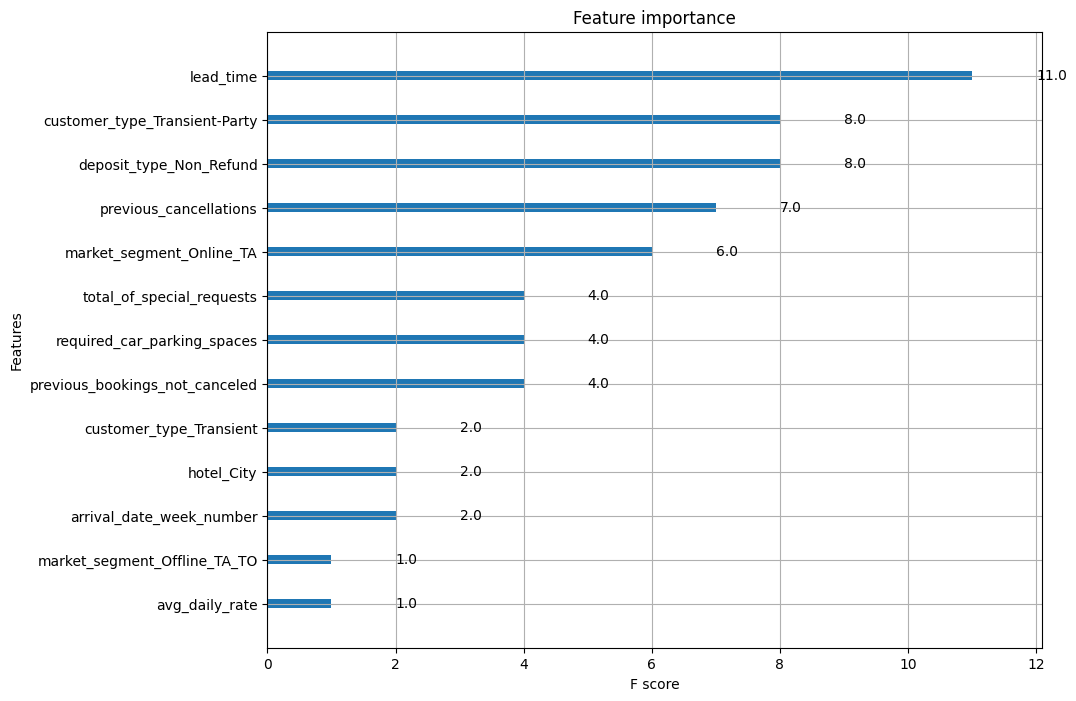

In [57]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8)

xgb.plot_importance(xgb_clf)

重要性是如何计算的？

importance_type（str，默认为“weight”）——可选范围：“weight”、“gain”或“cover”

- “weight”是特征在树中出现的次数
- “gain”是使用该特征的分割的平均增益
- “cover”是使用该特征的分割的平均覆盖率，其中覆盖率定义为受分割影响的样本数量

我们将重点关注前两个。增益是量化特征对提高准确性的贡献程度的方法。让我们试试增益，看看它与权重有何不同。

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

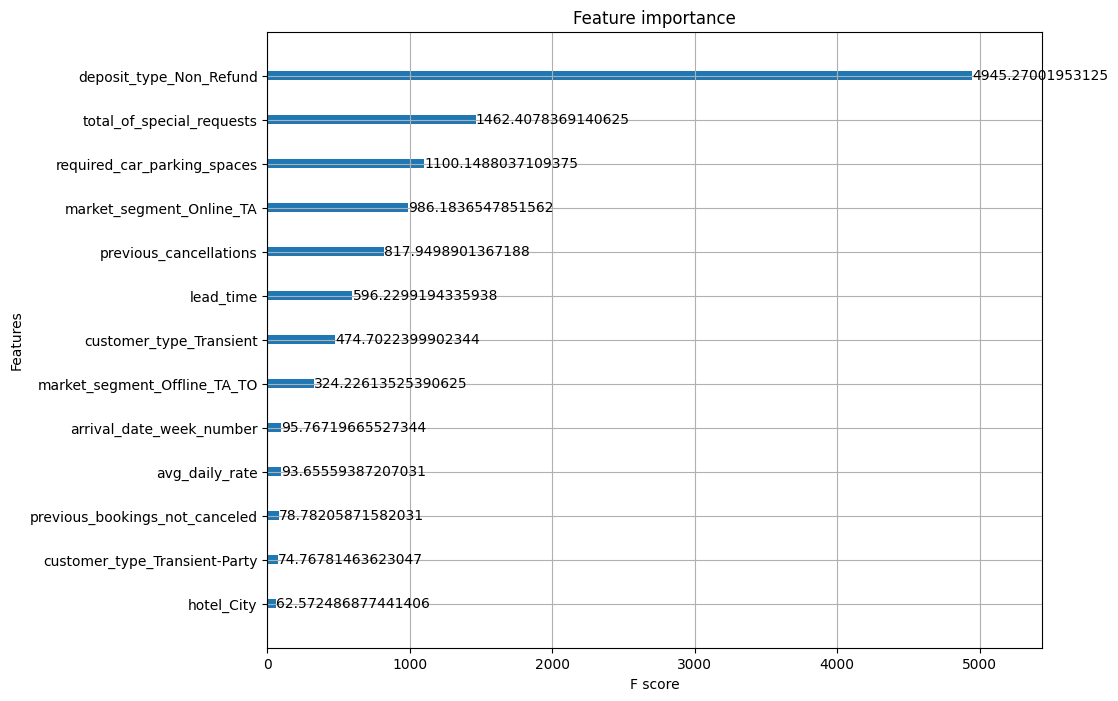

In [45]:
# Plot gain instead of weight
xgb.plot_importance(xgb_clf, importance_type="gain")

这里我们看到特征的排序在增益和权重之间有很大不同！这意味着

 1. 特征重要性可能是主观的，并且
 2. 特征在树上的出现次数不一定与它带来的增益相关。

 例如，二元变量在树上出现的次数不如连续变量多，因为只有两个输出。然而，它仍然可以是一个强大的特征。

### 生成决策树图
第二个方便的可视化函数是 plot_tree()，它可以直观地在您的模型中生成决策树。请记住，模型中有多个树。

它接受拟合的 XGBoost 模型，并使用 num_trees 参数，您可以指示要查看哪棵树。
例如，如果我有 n_estimator=3，我可以将 num_trees 参数设置为 0、1 或 2，以分别查看第一、第二或第三棵树。

<Axes: >

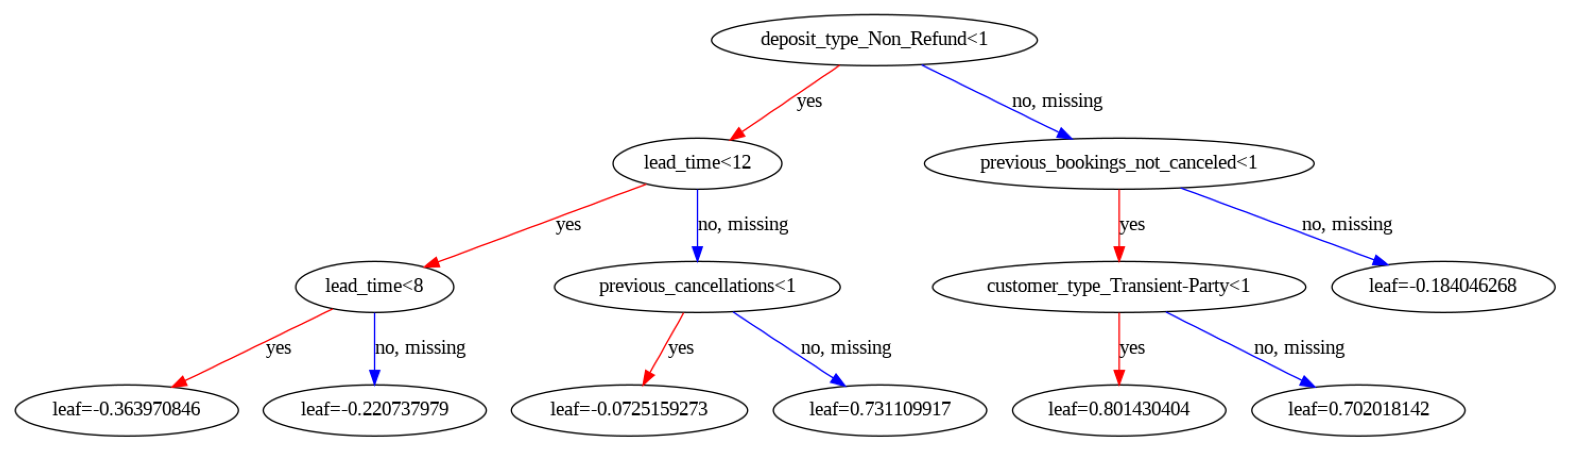

In [46]:
matplotlib.rcParams['figure.figsize'] = (20.0, 8)

# Plot the first tree
xgb.plot_tree(xgb_clf, num_trees=0)

叶子输出是原始分数。它在训练结束时转换为概率。

有一个参数叫做 rankdir。我们可以将其设置为 LR，这样决策树就会从左到右构建，而不是从上到下。

<Axes: >

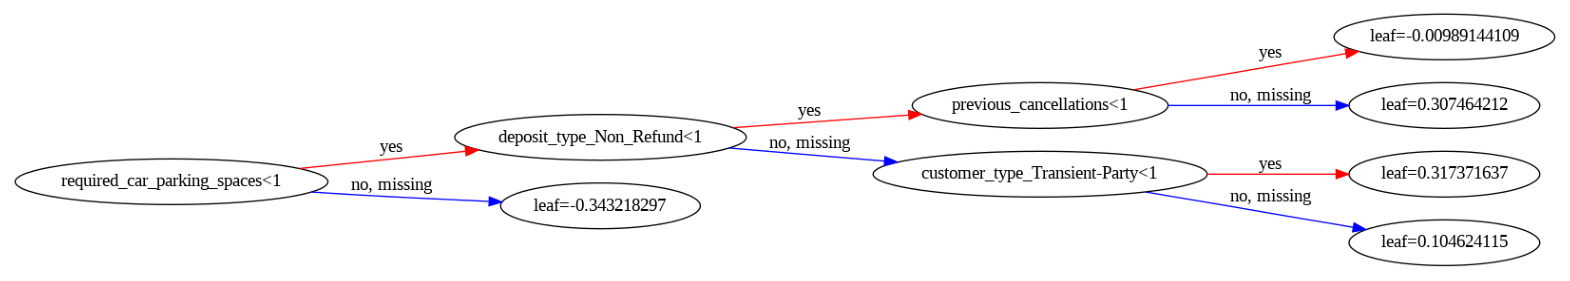

In [47]:
# Plot the last tree
xgb.plot_tree(xgb_clf, num_trees=9, rankdir='LR')

## 交叉验证Cross Validation in XGBoost
交叉验证被认为是评估模型性能的最佳实践。我们可以使用 xgboost.cv() 在 XGBoost 模型上有效地运行交叉验证。此方法是 XGBoost 核心库的一部分，而不是之前的 XGBoost scikit-learn API 的一部分。

### 转换DMatrix
DMatrix 是 XGBoost 的内部数据结构，旨在优化内存效率和训练速度。这是 XGBoost 比其他梯度提升实现具有更好的性能和效率的原因之一。

在上一个练习中，当我们使用 .fit() 拟合数据时，输入的数据集被转换为 DMatrix 数据。但是，要使用 xgboost.cv() 对象，我们需要首先将数据显式转换为 DMatrix。

In [60]:
# Convert X and y into a DMatrix
bookings_dmatrix = xgb.DMatrix(data=X,label=y)

### 使用 xgb.cv 进行交叉验证
注意：Scikit-learn 使用 n_estimator 来表示增强轮数或模型中的树数。在 XGBoost 中，它被称为 num_boost_rounds。

要定义增强器参数，通常的做法是创建一个字典来保存与各个增强器相关的所有参数。我们将这样做，并将目标函数定义为 binary:logistic，将最大树深度定义为 3。

In [62]:
# Define booster parameters using a dictionary
params = {"objective":"binary:logistic", 'max_depth': 3,'eval_metric':["error"]}

# Instantiate a CV object with 3 folds and 10 boosting rounds
xgb_cv = xgb.cv(dtrain=bookings_dmatrix, params=params, nfold=3, num_boost_round=10, seed=123)

# Inspect the results: how are they stored?
xgb_cv

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.238667,0.006745,0.239552,0.009779
1,0.233072,0.001330,0.233059,0.000903
2,0.233235,0.000955,0.233235,0.001217
3,0.233198,0.000752,0.233160,0.001495
4,0.232321,0.001424,0.232455,0.000993
5,0.232468,0.001139,0.232506,0.001140
6,0.192777,0.000860,0.192996,0.001304
7,0.189913,0.003105,0.190596,0.001231
8,0.191209,0.002874,0.191972,0.002059
9,0.191192,0.001752,0.191569,0.001774


### XGBoost 中的结果
我们的十个 boosting 行有十行。

XGBoost 文档中定义的错误：

二元分类错误率。计算方式为 #(错误案例)/#(所有案例)。对于预测，评估将把预测值大于 0.5 的实例视为正实例，其他的视为负实例。

这意味着我们需要从 1 中减去最后一轮 boosting 的测试错误平均值才能得到准确率。

In [63]:
# Caclulate accuracy
accuracy= 1 - xgb_cv["test-error-mean"].iloc[-1]

# Print the baseline accuracy
print("baseline cv accuracy:", accuracy)

baseline cv accuracy: 0.8084305120289114


现在让我们研究如何提高性能。

## 通过提前停止获得更多树(More trees with early stopping)
我们一直使用 10 棵树（又名 num_boost_rounds）。让我们添加更多树（40 棵而不是 10 棵），但一定要添加提前停止。

提前停止的工作原理是，在每一轮增强后针对保留集测试模型。如果保留指标（在我们的例子中是错误）在给定轮数（由 early_stopping_rounds 定义）后没有改善，则停止任何额外的增强轮数。如果模型持续改进至 num_boost_round，则不会发生提前停止。

这有助于自动选择增强轮数并最大限度地减少额外的训练时间。

In [64]:
# Increase the number of trees to 40 and set the early stopping rounds to 10
xgb_cv = xgb.cv(dtrain=bookings_dmatrix, params=params, nfold=3,
                    num_boost_round=40,early_stopping_rounds=10, seed=123)

# Caclulate accuracy
accuracy= 1 - xgb_cv["test-error-mean"].iloc[-1]

# Print the accuracy
print("accuracy:", accuracy)

accuracy: 0.8156027181483166


In [65]:
# Did early stopping happen?
xgb_cv

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.238667,0.006745,0.239552,0.009779
1,0.233072,0.001330,0.233059,0.000903
2,0.233235,0.000955,0.233235,0.001217
3,0.233198,0.000752,0.233160,0.001495
4,0.232321,0.001424,0.232455,0.000993
5,0.232468,0.001139,0.232506,0.001140
6,0.192777,0.000860,0.192996,0.001304
7,0.189913,0.003105,0.190596,0.001231
8,0.191209,0.002874,0.191972,0.002059
9,0.191192,0.001752,0.191569,0.001774


有 40 行，测试误差似乎在每一轮之后几乎持续下降。这意味着没有发生提前停止，因为我们的模型一直在改进。

我们通过增加提升树的数量来改善结果，但我们可以使用更多参数！

## 深入研究参数
除了设置提升轮数和提前停止轮数外，我们的树提升器还有许多其他参数。我们可以在树提升器参数文档中看到这一点。

在本节中，我们将介绍几个重要参数并了解它们的作用。

为了本次课程的目的，我们将使用 XGBClassifier() 和 25 个提升轮数来避免长时间的训练。

In [21]:
from sklearn.metrics import accuracy_score

# Instantiate the XGBClassifier with 25 boosting rounds
xgb_clf = xgb.XGBClassifier(n_estimators=25, random_state=123)

In [22]:
# Set max_depth to 10
xgb_clf.set_params(max_depth=10)

# Fit the classifier to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

# Compute the accuracy
accuracy_score(y_test, preds)

0.8349008642602949

### colsample_bytree
来自 XGBoost 文档：

构建每棵树时列的子采样率。每构建一棵树都会进行一次子采样。

本质上，这让我们可以限制构建每棵树时使用的列数。这增加了随机性，使模型对噪声更具鲁棒性。默认值为 1（即所有列），让我们尝试一个较小的值。

In [23]:
# Set colsample_bytree to 0.5
xgb_clf.set_params(colsample_bytree=0.5)

# Fit the classifier to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

# Compute the accuracy
accuracy_score(y_test, preds)

0.837874936451449

我们还可以限制树的每个深度级别或节点使用的列数。

来自 XGBoost 文档：


>  colsample_bylevel 是每个级别的列的子采样率。树中每达到一个新深度级别，就会进行一次子采样。列是从为当前树选择的列集中进行子采样的。

> colsample_bynode 是每个节点（分割）的列的子采样率。每次评估新的分割时都会进行一次子采样。列是从为当前级别选择的列集中进行子采样的。

### subsample
来自 XGBoost 文档：

训练实例的subsample。将其设置为 0.5 意味着 XGBoost 会在生长树之前随机采样一半的训练数据，这将防止过度拟合。
子采样将在每次增强迭代中发生一次。
范围：（0,1]
默认值为 1，我们试试 0.75。

这意味着我们的 25 棵树中的每一棵都将获得 75% 的训练数据的随机采样。每棵树将在不同的数据部分上进行训练，这增加了随机性（类似于 colsample_bytree）。

In [24]:
# Set subsample to 0.75
xgb_clf.set_params(subsample=0.75)

# Fit the classifier to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

# Compute the accuracy
accuracy_score(y_test, preds)

0.8380782918149466

### gamma
来自 XGBoost 文档：

>对树的叶节点进行进一步分区所需的最小损失减少。gamma 越大，算法越保守。
范围：[0,∞]
这决定节点是否会根据分割后的预期损失减少损失进行分割。gamma 表示节点分割所需的最小损失减少。

增加 gamma = 更少的分割 = 更少的复杂性

默认值为 0，因此在我们的例子中，节点始终会分割直到最大深度。让我们将其增加到 0.25。

In [25]:
# Set gamma to .25
xgb_clf.set_params(gamma=0.25)

# Fit the classifier to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

# Compute the accuracy
accuracy_score(y_test, preds)

0.8376970005083884

### 学习率（又名 eta）
来自 XGBoost 文档：

> 更新中使用的步长收缩可防止过度拟合。在每个提升步骤之后，我们可以直接获得新特征的权重，并且 eta 会缩小特征权重以使提升过程更加保守。
范围：[0,1]
学习率会影响模型学习的速度。

梯度提升通过依次向模型添加弱学习者来工作。每个新的弱学习者都会尝试纠正前面树的残差。这使得模型很容易过度拟合。学习率可以通过在将当前树的结果权重传递给下一棵树之前缩小它们来帮助减慢学习速度。

我们模型的学习率目前为 0.1。如果我们将其更改为 0.3，会发生什么？

In [26]:
# Set learning rate to .3
xgb_clf.set_params(learning_rate=0.3)

# Fit the classifier to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

# Compute the accuracy
accuracy_score(y_test, preds)

0.8376970005083884

学习率和树的数量应该一起调整。如果我们降低学习率，我们需要确保有足够的树来学习一些东西，避免严重欠拟合。因此，低学习率将需要更多的提升轮次。

### reg_alpha
来自 XGBoost 文档：

> 权重上的 L1 正则化项。增加此值将使模型更加保守。

> L1 通常被称为套索回归。它是一种基础正则化技术，这意味着它旨在通过阻止复杂模型来减少过度拟合。在梯度提升的情况下，L1 通过增加叶权重的惩罚来实现这一点。增加 alpha 会使基础学习者的叶权重趋近于 0。

默认值为 0，这意味着我们的模型中目前没有 alpha 正则化。让我们用 0.01 的值激活 L1。

In [27]:
# set reg_alpha to .1
xgb_clf.set_params(reg_alpha=0.01)

# Fit the classifier to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

# Compute the accuracy
accuracy_score(y_test, preds)

0.8355617691916625

### reg_lambda
L2，又称ridge regression，也可以通过参数 reg_lambda 获得。众所周知，L2 的惩罚比 L1 更平滑。这意味着叶权重会平滑地减少，而叶权重稀疏的风险较小。所以，一定要尝试我们不同的正则化技术！

让我们看看我们手动更改后的结果参数。

可能参数组合有很多种，我们无法手动调整和选择它们。

## 使用随机搜索进行超参数调整

网格搜索和随机搜索是超参数调整最流行的方法。但是，如果您在大型超参数空间中搜索并处理多个超参数，则网格搜索的计算成本会很高。在最后一节中，这就是我们使用随机搜索的原因，因为它不会尝试所有超参数值。在随机搜索中，从指定的概率分布中抽取固定数量的超参数设置。

XGBoost 没有内置的网格搜索函数，因此我们需要使用 scikit-learn 的 RandomizedSearchCV。这意味着我们必须使用 XGBClassifier()，因为它与 scikit-learn 兼容。

RandomizedSearchCV() 函数接受以下参数：

- estimator：正在拟合的估计器，这里是 XGBoost。
- param_distributions：与 params 不同 - 这是可能使用的超参数的分布。
- cv：交叉验证迭代次数
- n_iter：可供选择的超参数组合数
- verbose：打印更多输出

In [66]:
from sklearn.model_selection import RandomizedSearchCV

# Define a parameter grid
rs_param_grid = {
    # max_depth: values from 3 to 12
    'max_depth': list((range(3,12))),
    # alpha: values 0, .001, .01, .1
    'alpha': [0,0.001, 0.01,0.1,1],
    # subsample: values 0.25,0.5,0.75, 1
    'subsample': [0.5,0.75,1],
    # learning rate: ten values between 0.01 - 0.5
    'learning_rate': np.linspace(0.01,0.5, 10),
    # n_estimators: values 10, 25, 40
    'n_estimators': [10, 25, 40]
    }


# Insantiate XGBoost Clasifier
xgb_clf = xgb.XGBClassifier(random_state=123)

# Instantiate RandomizedSearchCV()
xgb_rs = RandomizedSearchCV(estimator=xgb_clf,param_distributions=rs_param_grid,
                                cv=3, n_iter=5, verbose=2, random_state=123)

# Train the model on the training set
xgb_rs.fit(X_train, y_train)

# Print the best parameters and highest accuracy
print("Best parameters found: ", xgb_rs.best_params_)
print("Best accuracy found: ", xgb_rs.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time=   0.4s
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time=   0.4s
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time=   0.4s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time=   0.7s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time=   1.8s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time=   1.7s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=8, n_estimators=40, subsample=0.75; total time=   0.8s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=8, n_estimators=40, subsample=0.75; total time=   0.8s
[CV] END

# 模型投产



## JAVA服务中应用
### SkLearn2PMML

```python
import pandas

iris_df = pandas.read_csv("Iris.csv")

iris_X = iris_df[iris_df.columns.difference(["Species"])]
iris_y = iris_df["Species"]

from sklearn.tree import DecisionTreeClassifier
from sklearn2pmml.pipeline import PMMLPipeline

pipeline = PMMLPipeline([
	("classifier", DecisionTreeClassifier())
])
pipeline.fit(iris_X, iris_y)

from sklearn2pmml import sklearn2pmml

sklearn2pmml(pipeline, "DecisionTreeIris.pmml", with_repr = True)
```
### jpmml-evaluator




```xml
<dependency>
	<groupId>org.jpmml</groupId>
	<artifactId>pmml-evaluator</artifactId>
	<version>1.6.6</version>
</dependency>
```


```java
// Building a model evaluator from a PMML file
Evaluator evaluator = new LoadingModelEvaluatorBuilder()
	.load(new File("model.pmml"))
	.build();

// Perforing the self-check
evaluator.verify();

// Printing input (x1, x2, .., xn) fields
List<InputField> inputFields = evaluator.getInputFields();
System.out.println("Input fields: " + inputFields);

// Printing primary result (y) field(s)
List<TargetField> targetFields = evaluator.getTargetFields();
System.out.println("Target field(s): " + targetFields);

// Printing secondary result (eg. probability(y), decision(y)) fields
List<OutputField> outputFields = evaluator.getOutputFields();
System.out.println("Output fields: " + outputFields);

// Iterating through columnar data (eg. a CSV file, an SQL result set)
while(true){
	// Reading a record from the data source
	Map<String, ?> arguments = readRecord();
	if(arguments == null){
		break;
	}

	// Evaluating the model
	Map<String, ?> results = evaluator.evaluate(arguments);

	// Decoupling results from the JPMML-Evaluator runtime environment
	results = EvaluatorUtil.decodeAll(results);

	// Writing a record to the data sink
	writeRecord(results);
}

// Making the model evaluator eligible for garbage collection
evaluator = null;
```



# 推荐资料传送门
*  原稿论文：
[ XGBoost: A Scalable Tree Boosting System](https://arxiv.org/pdf/1603.02754)
*  [视频讲解](https://www.youtube.com/watch?v=OtD8wVaFm6E&list=PLblh5JKOoLULU0irPgs1SnKO6wqVjKUsQ&index=1) （B站也有搬运版）
* [github](https://github.com/dmlc/xgboost)
* [google Machine Learning ](https://developers.google.com/machine-learning/crash-course/linear-regression)
* [SKlearn xgboost](https://xgboost.readthedocs.io/en/latest/python/sklearn_estimator.html)
* [jpmml ](https://github.com/jpmml)